##### Pycolmap API: https://github.com/colmap/colmap/tree/main/pycolmap

In [1]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook

tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path
import numpy as np

from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_exhaustive,
)
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

import pycolmap
pycolmap.logging.minloglevel = 2

[2024/11/21 15:29:16 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 2048, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}


feature_conf:  {'output': 'feats-disk', 'model': {'name': 'disk', 'max_keypoints': 2048}, 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
matcher_conf:  {'output': 'matches-disk-lightglue', 'model': {'name': 'lightglue', 'features': 'disk'}}
2 mapping images
['seq1/frame_00018.jpg', 'seq1/frame_00000.jpg']


/Rocket_ssd/miniconda3/envs/pose_estimation/lib/python3.8/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


  0%|          | 0/2 [00:00<?, ?it/s]

[2024/11/21 15:29:17 hloc INFO] Finished exporting features.
[2024/11/21 15:29:17 hloc INFO] Found 1 pairs.
[2024/11/21 15:29:17 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
/Rocket_ssd/miniconda3/envs/pose_estimation/lib/python3.8/site-packages/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


  0%|          | 0/1 [00:00<?, ?it/s]

[2024/11/21 15:29:17 hloc INFO] Finished exporting matches.
[2024/11/21 15:29:17 hloc INFO] Creating an empty database...
[2024/11/21 15:29:18 hloc INFO] Importing images into the database...
[2024/11/21 15:29:18 hloc INFO] Importing features into the database...


  0%|          | 0/2 [00:00<?, ?it/s]

[2024/11/21 15:29:18 hloc INFO] Importing matches into the database...


  0%|          | 0/1 [00:00<?, ?it/s]

[2024/11/21 15:29:18 hloc INFO] Performing geometric verification of the matches...
[2024/11/21 15:29:18 hloc INFO] Running 3D reconstruction...
[2024/11/21 15:29:18 hloc INFO] Reconstructed 1 model(s).
[2024/11/21 15:29:18 hloc INFO] Largest model is #0 with 2 images.
[2024/11/21 15:29:18 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 2
	num_cameras = 2
	num_points3D = 730
	num_observations = 1460
	mean_track_length = 2
	mean_observations_per_image = 730
	mean_reprojection_error = 0.28472
	num_input_images = 2


Successful trianglation: 2 / 2
Number of 3D Points:  730
Image(image_id=1, camera_id=1, name="seq1/frame_00000.jpg", triangulated=730/1422)
Image(image_id=2, camera_id=2, name="seq1/frame_00018.jpg", triangulated=730/1339)


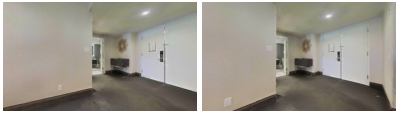

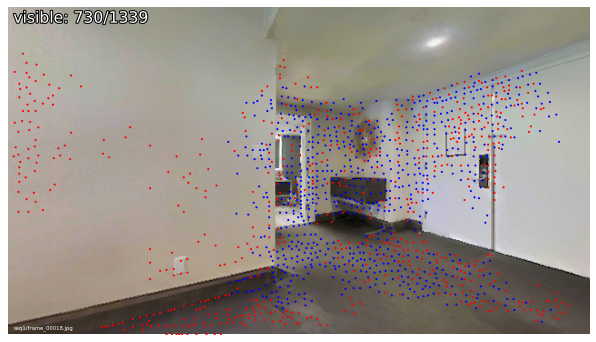

In [2]:
data_path = '/Rocket_ssd/dataset/data_litevloc/matterport3d/map_free_eval/test/s00000/'
images = Path(data_path)
outputs = Path("outputs_colmap")
!rm -rf $outputs
sfm_pairs = outputs / "pairs-sfm.txt"
loc_pairs = outputs / "pairs-loc.txt"
sfm_dir = outputs / "sfm"
features = outputs / "features.h5"
matches = outputs / "matches.h5"

feature_conf = extract_features.confs["disk"]
feature_conf['model']['max_keypoints'] = 2048

matcher_conf = match_features.confs["disk+lightglue"]

print('feature_conf: ', feature_conf)
print('matcher_conf: ', matcher_conf)

##### Load Iamges
references = [f'seq1/frame_{i:05}.jpg' for i in range(20)]
print(len(references), "mapping images")
print(references)
plot_images([read_image(images / r) for r in references], dpi=25)

# Reconstruct the scene
extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches)

##### Provide known camera parameters
# opts = dict(camera_model='PINHOLE', camera_params=','.join(map(str, [205.47, 205.47, 320, 180])))
# opts = dict(camera_model='SIMPLE_RADIAL', camera_params=','.join(map(str, [542.8, 481.30, 271.85, 0])))
# model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references, 
#                             image_options=opts,
#                             mapper_options=dict(ba_refine_focal_length=False, ba_refine_extra_params=False),
#                             verbose=False)
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)

if model is not None or len(model.points3D) > 500:
    visualization.visualize_sfm_2d(model, images, color_by="visibility", n=1)
    cnt = sum(1 for image in model.images.values() if image.num_points3D > 500)
    print('Successful trianglation:', cnt, '/', len(model.images))
    print('Number of 3D Points: ', len(model.points3D))
    for image in model.images.values(): print(image)

In [4]:
for image_id, image in model.images.items():
    print(image)
    print(image.cam_from_world)
    print(type(image))
    camera = model.cameras[image.camera_id]
    print(camera)
    break
if model is not None or len(model.points3D) > 500:
    fig = viz_3d.init_figure()
    viz_3d.plot_reconstruction(fig, model, color="rgba(255,0,0,0.5)", name="mapping", points_rgb=True)
    fig.show()

Image(image_id=1, camera_id=1, name="seq1/frame_00000.jpg", triangulated=1050/1422)
Rigid3d(quat_xyzw=[0.0157525, 0.135215, 0.00222794, 0.990689], t=[0.440286, -0.0858008, -0.148088])
<class 'pycolmap.Image'>
Camera(camera_id=1, model=SIMPLE_RADIAL, width=640, height=360, params=[204.261194, 320.000000, 180.000000, -0.003959] (f, cx, cy, k))


In [5]:
query = 'seq0/frame_00000.jpg'
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True)

[2024/11/21 13:40:52 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 2048, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}


  0%|          | 0/1 [00:00<?, ?it/s]

[2024/11/21 13:40:52 hloc INFO] Finished exporting features.
[2024/11/21 13:40:52 hloc INFO] Found 20 pairs.
[2024/11/21 13:40:52 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}


  0%|          | 0/20 [00:00<?, ?it/s]

[2024/11/21 13:40:52 hloc INFO] Finished exporting matches.


PosixPath('outputs_colmap/matches.h5')

found 728/1594 inlier correspondences.


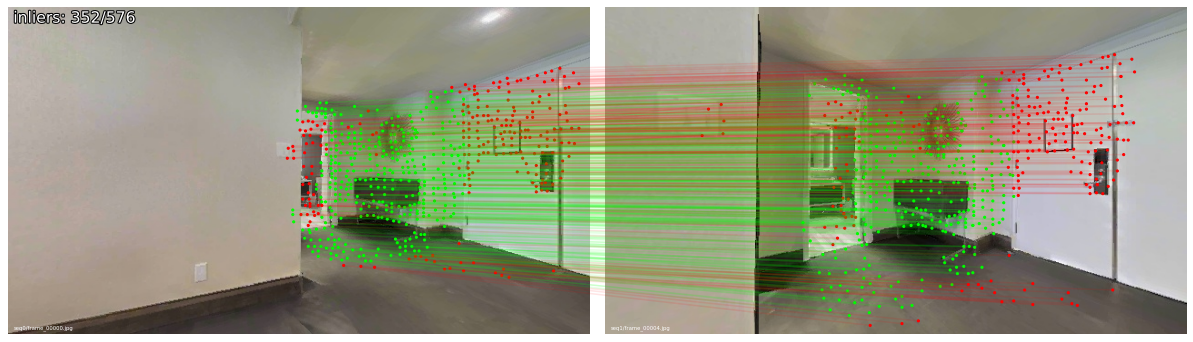

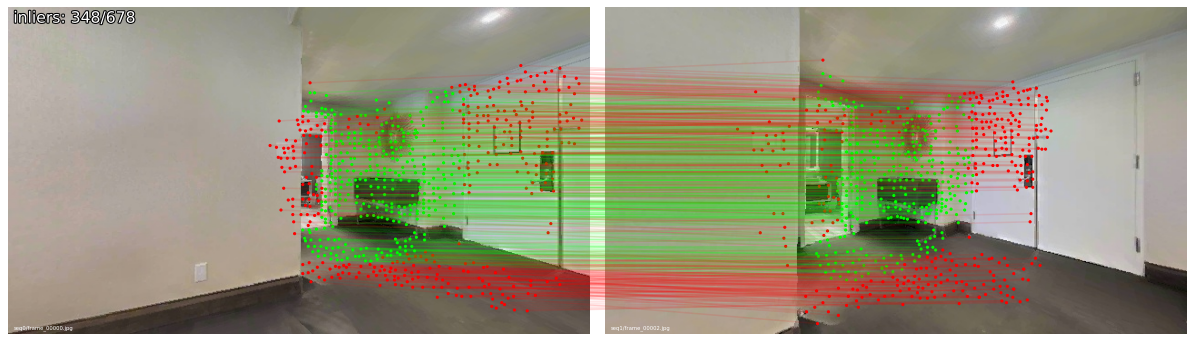

In [6]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(r).image_id for r in references if model.find_image_with_name(r) is not None]
conf = {
    "estimation": {"ransac": {"max_error": 12}},
    "refinement": {"refine_focal_length": True, "refine_extra_params": True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)


In [7]:
pose = pycolmap.Image(cam_from_world=ret["cam_from_world"])
viz_3d.plot_camera_colmap(fig, pose, camera, color="rgba(0,255,0,0.5)", name=query, fill=True)
viz_3d.plot_camera_colmap(fig, pycolmap.Image(cam_from_world=pycolmap.Rigid3d()), camera, color="rgba(0,0,255,0.5)", name='world', fill=True)
# visualize 2D-3D correspodences
inl_3d = np.array(
    [model.points3D[pid].xyz for pid in np.array(log["points3D_ids"])[ret["inliers"]]]
)
viz_3d.plot_points(fig, inl_3d, color="lime", ps=1, name=query)
fig.show()

In [8]:
# Demo for align poses with predicted and groundtruth: scale, rotation, translation
import torch
from pathlib import Path

# Store gt poses
poses_load = {}
scene_root = Path(data_path)
with (scene_root / 'poses.txt').open('r') as f:
    for line in f.readlines():
        if '#' in line:
            continue
        line = line.strip().split(' ')
        img_name = line[0]
        qt = np.array(list(map(float, line[1:])))
        pose = pycolmap.Rigid3d()
        pose.translation = qt[4:]
        pose.rotation = pycolmap.Rotation3d(np.roll(qt[:4], -1))
        poses_load[img_name] = pose

# Store pred and gt poses
poses_pred = torch.zeros((0, 4, 4))
poses_gt = torch.zeros((0, 4, 4))
for image_id, image in model.images.items():
    # Pose: from camera to world
    camera = model.cameras[image.camera_id]
    if image.num_points3D < 500: # filter out bad images with few 3D points
        continue
    tmp_pose = torch.from_numpy(np.eye(4))
    tmp_pose[:3, :] = torch.from_numpy(image.cam_from_world.matrix())
    poses_pred = torch.cat((poses_pred, tmp_pose.unsqueeze(0)), dim=0)

    tmp_pose = torch.from_numpy(np.eye(4))
    tmp_pose[:3, :] = torch.from_numpy(poses_load[image.name].matrix())
    poses_gt = torch.cat((poses_gt, tmp_pose.unsqueeze(0)), dim=0)

tmp_pose = torch.from_numpy(np.eye(4))
tmp_pose[:3, :] = torch.from_numpy(ret['cam_from_world'].matrix())
poses_pred = torch.cat((poses_pred, tmp_pose.unsqueeze(0)), dim=0)

tmp_pose = torch.from_numpy(np.eye(4))
tmp_pose[:3, :] = torch.from_numpy(poses_load['seq0/frame_00000.jpg'].matrix())
poses_gt = torch.cat((poses_gt, tmp_pose.unsqueeze(0)), dim=0)

# align
from estimator import WEIGHTS_DIR, THIRD_PARTY_DIR, BaseEstimator
from estimator.utils import to_numpy, resize_to_divisible, add_to_path
add_to_path(THIRD_PARTY_DIR.joinpath('CF-3DGS'), insert=0)

from utils.utils_poses.align_traj import align_ate_c2b_use_a2b
from utils.utils_poses.comp_ate import compute_rpe, compute_ATE
from utils.vis_utils import plot_pose

c2ws_est_aligned = align_ate_c2b_use_a2b(poses_pred, poses_gt)

ate = compute_ATE(poses_gt.cpu().numpy(), poses_pred.cpu().numpy())
print('ATE before alignment: ', ate)
# for i in range(1, len(poses_pred), 1): print(poses_pred[i, :3, 3].T, poses_gt[i, :3, 3].T)
# print(poses_pred[-1, :3, 3].T, poses_gt[-1, :3, 3].T)

ate = compute_ATE(poses_gt.cpu().numpy(), c2ws_est_aligned.cpu().numpy())
print('ATE after alignment: ', ate)
for i in range(1, len(c2ws_est_aligned), 1): print(c2ws_est_aligned[i, :3, 3].T, poses_gt[i, :3, 3].T)
print(c2ws_est_aligned[-1, :3, 3].T, poses_gt[-1, :3, 3].T)

%matplotlib inline
plot_pose(poses_gt.cpu().numpy(), c2ws_est_aligned.cpu().numpy(), str(scene_root / 's00000'))


ModuleNotFoundError: No module named 'evo'

In [12]:
print(camera)
print(camera.params[0])
print(localizer.reconstruction.compute_mean_reprojection_error())
print(model.num_points3D())

Camera(camera_id=20, model=SIMPLE_RADIAL, width=640, height=360, params=[204.507698, 320.000000, 180.000000, -0.005150] (f, cx, cy, k))
204.50769769119694
0.8447689724752858
3680
